<a href="https://colab.research.google.com/github/rishimamilla/SIH_Agricorp/blob/Model/BW_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow

In [ ]:
pip install kaggle

In [ ]:
# Import necessary libraries
import os
import zipfile
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.optimizers import Adam

In [ ]:
img_height = 224
img_width = 224
batch_size = 64

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d arjuntejaswi/plant-village

Dataset URL: https://www.kaggle.com/datasets/arjuntejaswi/plant-village
License(s): unknown
 96% 317M/329M [00:10<00:00, 62.0MB/s]
100% 329M/329M [00:10<00:00, 33.9MB/s]


In [ ]:
dataset_zip = "plant-village.zip"
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall("data")

In [ ]:
data_dir = "data/PlantVillage"

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 20638 files belonging to 15 classes.
Using 16511 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 20638 files belonging to 15 classes.
Using 4127 files for validation.


In [ ]:
class_names = train_ds.class_names
print("Class Names:", class_names)

Class Names: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [ ]:
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
mobilenet_v2_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
mobilenet_v2_base.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = mobilenet_v2_base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

In [ ]:
model = tf.keras.Model(inputs, outputs)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
)

# Step 9: Evaluate the model on validation set
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Print training history
#print("Training History:")
#print(f"Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")


Epoch 1/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 51s 145ms/step - accuracy: 0.6974 - loss: 0.9737 - val_accuracy: 0.8604 - val_loss: 0.3892
Epoch 2/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 61s 97ms/step - accuracy: 0.9035 - loss: 0.2972 - val_accuracy: 0.9021 - val_loss: 0.2777
Epoch 3/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 42s 100ms/step - accuracy: 0.9309 - loss: 0.2092 - val_accuracy: 0.9106 - val_loss: 0.2473
Epoch 4/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 25s 99ms/step - accuracy: 0.9434 - loss: 0.1704 - val_accuracy: 0.9263 - val_loss: 0.2124
Epoch 5/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 40s 96ms/step - accuracy: 0.9551 - loss: 0.1364 - val_accuracy: 0.9254 - val_loss: 0.2189
Epoch 6/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 25s 98ms/step - accuracy: 0.9664 - loss: 0.1169 - val_accuracy: 0.9205 - val_loss: 0.2340
Epoch 7/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - accuracy: 0.9696 - loss: 0.0965 - val_accuracy: 0.9324 - val_loss: 0.2004
Epoch 8/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - accuracy: 0.9780 - loss: 0.077

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Predictions on validation set
val_images, val_labels = [], []
for images, labels in val_ds:
    val_images.extend(images.numpy())
    val_labels.extend(labels.numpy())

# Convert lists to numpy arrays
val_images = np.array(val_images)
val_labels = np.array(val_labels)

# Make predictions on the validation set
val_predictions = model.predict(val_images)
val_predicted_classes = np.argmax(val_predictions, axis=-1)

# Confusion Matrix
conf_matrix = confusion_matrix(val_labels, val_predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(val_labels, val_predicted_classes, target_names=class_names)
print("Classification Report:")
print(class_report)


65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.9465 - loss: 0.2164
Validation Loss: 0.2386
Validation Accuracy: 0.9450
129/129 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step
Confusion Matrix:
[[170   3   0   0   0   0   1   0   0   1   0   0   1   0   0]
 [  2 276   0   1   1   0   0   0   0   0   0   0   0   0   0]
 [  0   0 188   4   0   0   0   0   0   2   0   0   0   0   0]
 [  0   1   1 212   2   0   0   6   0   1   1   0   0   0   0]
 [  0   1   0   4  24   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 393   4   3   0   9   0   4   1   0   0]
 [  0   0   0   1   0   6 165   5   4   6   1   7   4   0   1]
 [  0   0   0   1   0   2  11 350   3   2   0   0   0   0   0]
 [  0   0   0   0   0   0   2   4 192   8   2   0   0   0   0]
 [  0   0   0   0   0   5   6   1   1 316   0   7   0   0   1]
 [  0   0   0   1   0   0   3   0   4   3 289  18   2   0   0]
 [  0   0   0   0   0   3   2   2   1   5   7 263   1   0   0]
 [  0   0   0   0   0   1   1   0   2   3   3   1 668   1

In [ ]:
from google.colab import drive
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Mount Google Drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Number of classes in model: 15
Confusion Matrix:
[[170   3   0   0   0   0   1   0   0   1   0   0   1   0   0]
 [  2 276   0   1   1   0   0   0   0   0   0   0   0   0   0]
 [  0   0 188   4   0   0   0   0   0   2   0   0   0   0   0]
 [  0   1   1 212   2   0   0   6   0   1   1   0   0   0   0]
 [  0   1   0   4  24   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 393   4   3   0   9   0   4   1   0   0]
 [  0   0   0   1   0   6 165   5   4   6   1   7   4   0   1]
 [  0   0   0   1   0   2  11 350   3   2   0   0   0   0   0]
 [  0   0   0   0   0   0   2   4 192   8   2   0   0   0   0]
 [  0   0   0   0   0   5   6   1   1 316   0   7   0   0   1]
 [  0   0   0   1   0   0   3   0   4   3 289  18   2   0   0]
 [  0   0   0   0   0   3   2   2   1   5   7 263   1   0   0]
 [  0   0   0   0   0   1   1   0   2   3   3   1 668   1   0]
 [  0   0   0   0   0   0   1   0   0   0   0   0   0  73   0]
 [  0   0   0   0   0   1   1   3   0   0   3   9   0   0 321]]
Using

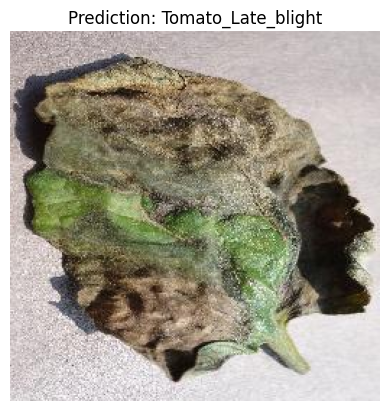

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Ensure class_names matches the number of classes in the model
print("Number of classes in model:", len(class_names))

# Make sure you have the correct number of class names
if len(class_names) != len(np.unique(val_labels)):
    print(f"Warning: Number of class names ({len(class_names)}) does not match number of unique labels in validation set ({len(np.unique(val_labels))}).")

# Generate confusion matrix and classification report
conf_matrix = confusion_matrix(val_labels, val_predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Generate classification report with specified labels
'''class_report = classification_report(val_labels, val_predicted_classes, target_names=class_names, zero_division=0)
print("Classification Report:")
print(class_report)'''

# Path to your images folder on Google Drive
images_folder = "/content/drive/MyDrive/Input"

# List all image files inside the folder
image_files = [os.path.join(images_folder, file) for file in os.listdir(images_folder) if file.endswith(('jpg', 'jpeg', 'png'))]

# Select an image for prediction
if len(image_files) > 0:
    input_img_path = image_files[0]
else:
    raise FileNotFoundError("No image files found in the specified folder.")

print(f"Using image: {input_img_path} for prediction.")

def load_and_preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((img_height, img_width))  # Resize to match model input
    image_array = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
    return image_array

image_array = load_and_preprocess_image(input_img_path)

# Make predictions
predictions = model.predict(image_array)
predicted_class = np.argmax(predictions, axis=-1)

# Check if predicted class index is within the valid range
predicted_index = predicted_class[0]
if predicted_index < len(class_names):
    print(f"Predicted Class Label: {class_names[predicted_index]}")
else:
    print(f"Predicted Class Index {predicted_index} is out of range.")

def display_image(image_path, title):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

display_image(input_img_path, f"Prediction: {class_names[predicted_index] if predicted_index < len(class_names) else 'Unknown'}")

In [ ]:
import os

# Check if the file exists
print(os.listdir('/content/drive/MyDrive/Input'))


['2.jpeg', '13.jpeg', '5.jpeg', '9.jpeg', '6.jpeg', '10.jpeg', '3.jpeg', '19.jpeg', '14.jpeg', '4.jpeg', '18.jpeg', '12.jpeg', '8.jpeg', '17.jpeg', '1.jpeg', '11.jpeg', '15.jpeg', '16.jpeg', '7.jpeg', '25.jpg', '21.jpg', '26.jpg', '28.jpg', '20.jpg', '29.jpg', '24.jpg', '31.jpg', '22.jpg', '23.jpg', '27.jpg', '30.jpg', '32.jpg', '33.jpg', 'crop_fertilizersAlso.json']


In [44]:
predicted_class_label = class_names[predicted_index]
print(f"Class: {predicted_class_label}")

Class: Tomato_Late_blight


In [ ]:
import json

# Path to your JSON file in Google Drive
json_file_path = '/content/drive/MyDrive/Input/crop_fertilizersAlso.json'

# Load JSON data from the file
with open(json_file_path, 'r') as file:
    data = json.load(file)


In [45]:
for plant in data['plants']:
    if plant['crop_with_disease'] == predicted_class_label:
        print(f"Crop Name: {plant['crop_name']}")
        print(f"Disease: {plant['crop_disease']}")
        print(f"Measures to Cure: {', '.join(plant['measures_to_cure'])}")
        print(f"Prevention: {', '.join(plant['prevention'])}")
        print(f"Fertilizer Ingredients: {', '.join(plant['fertilizer_ingredients'])}")
        print(f"Fertilizer Brands: {', '.join(plant['fertilizer_brands'])}")
        print(f"Pesticides: {', '.join(plant['pesticides'])}")
        break

KeyError: 'crop_with_disease'